In [1]:
"""
Global Feature Selection 
    - X = 'Depth (m)','iso_classes_encoded', 'Oberhollenzer_classes', 
    'σ,v (kPa)', 'σ',v (kPa)'.
    
    - Y = 'qc (MPa)','fs (kPa)'.
"""
#General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger
from sklearn.model_selection import train_test_split
import time

'''
PreProcessing
''' 
#Loading Database
df_cpt=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Target_Encoded_Database.csv')

#Transforming to DataFrame
df_cpt = pd.DataFrame(df_cpt)
df_cpt = df_cpt.drop(columns='Unnamed: 0')

#Dropping zeros from qc
df_cpt = df_cpt[~(df_cpt[['qc (MPa)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['qc (MPa)']] < 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['SBT (-)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['SBTn (-)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['Mod. SBTn (-)']] == 0).any(axis = 1)]

#Transforming to NumpyArray
df_cpt = df_cpt.to_numpy()

'''
Inputs
'''
X = df_cpt[:, [11, 17, 18, 19, 27]]

#1--> D'Depth (m)' --> index: 1
#2 --> 'σ,v (kPa)' --> index: 9
#3 --> "σ',v (kPa)" --> index: 11
#4 --> 'SBT (-)' --> index: 17
#5 --> 'SBTn (-)' --> index: 18
#6 --> 'Mod. SBTn (-)' --> index: 19 
#7 --> 'Ic (-)' --> index: 21
#8 --> 'Ic SBT (-)' --> index:22 
#9 --> 'Ib (-)' --> index: 23
#10 --> 'Oberhollenzer_classes' --> index: 24
#11 --> 'iso_classes_encoded' --> index: 27

#X=X.to(device) #To GPU

'''
Outputs
'''
y = df_cpt[:, [2, 3]] 

#1 --> 'qc (MPa)' --> index: 2
#2 --> 'fs (kPa)' --> index: 3

#y=y.to(device) #To GPU

#Scaling the and preparing the data
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

#Scaling the Data
scaledX=scalerX.fit_transform(X)
scaledY=scalerY.fit_transform(y)

#Train & Test split
X_train, X_test, y_train, y_test = train_test_split(scaledX, scaledY, 
                                                   test_size = 0.20)

In [2]:
'''
Neural Network Structure
'''
#Callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, 
                   patience = 30)
csv_logger = CSVLogger('DNN_CPTNet_Colonel_03.csv', 
                       separator = ',', append = False)
model_checkpoint = ModelCheckpoint('DNN_CPTNet_Colonel_03.hdf5', 
                                   monitor = 'val_loss', verbose = 1, save_best_only = True)

#Optimizer
l_r = 0.001
momentum = 0.9
opt_1 = keras.optimizers.Nadam(learning_rate = l_r)
opt_2 = keras.optimizers.SGD(learning_rate = l_r, momentum = momentum)
opt_3 = tf.keras.optimizers.RMSprop(learning_rate = 0.001, rho=0.9, momentum = 0.0, epsilon=1e-07)
opt_4 = keras.optimizers.Adam(learning_rate = l_r)

#Weight Initializer
init_mode_1 = 'he_normal'
init_mode_2 = tf.keras.initializers.LecunNormal()

#Activation functions
trelu = tf.keras.layers.ThresholdedReLU(theta = 1.0)
prelu = tf.keras.layers.PReLU()
leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.3)

#Model
model = Sequential()

model.add(Dense(21, input_dim = 5,
                activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(2, activation = 'linear', 
                kernel_initializer = init_mode_1))

model.compile(optimizer = opt_1, loss = 'mse', 
              metrics=['mse', 'mae', 'mape'])

#Initial time
start_time = time.time()

#Fitting Network
history =  model.fit(X_train, y_train, epochs = 500, batch_size = 64,
                     validation_split = 0.25, callbacks = [model_checkpoint, csv_logger, es])

#Final time
end_time = (time.time() - start_time)
print('The running time is: %.2f minutes' %(end_time/60))

Epoch 1/500
7929/7929 [==============================] - 15s 2ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0283 - mape: 2351.0070 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0197 - val_mape: 1151.0638

Epoch 00001: val_loss improved from inf to 0.00152, saving model to DNN_CPTNet_Colonel_03.hdf5
Epoch 2/500
7929/7929 [==============================] - 13s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0194 - mape: 844.1344 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0182 - val_mape: 1049.4315

Epoch 00002: val_loss improved from 0.00152 to 0.00146, saving model to DNN_CPTNet_Colonel_03.hdf5
Epoch 3/500
7929/7929 [==============================] - 13s 2ms/step - loss: 0.0015 - mse: 0.0015 - mae: 0.0188 - mape: 838.1613 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0204 - val_mape: 875.9100

Epoch 00003: val_loss improved from 0.00146 to 0.00141, saving model to DNN_CPTNet_Colonel_03.hdf5
Epoch 4/500
7929/7929 [==============================] - 13s 2ms/step - loss: 0.001

In [3]:
#Making a prediction
y_pred = model.predict(X_test)

#Inverse transform
y_test = scalerY.inverse_transform(y_test)
y_pred = scalerY.inverse_transform(y_pred)

In [4]:
#Metrics Global
print('Metrics Global')
mae = mean_absolute_error(y_test, y_pred)
print('The mae is: %.4f' %mae)
mse = mean_squared_error(y_test, y_pred)
print('The mse is: %.4f' %mse)
rmse = np.sqrt(mse).mean()
print('The rmse is: %.4f' %rmse)
r2 = r2_score(y_test, y_pred)
print('The R2 is: %.4f' %r2)

print('____________________________________________')
#Metrics for the qc
print('Metrics for qc')
mae_qc = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
print('The mae is: %.4f MPa' %mae_qc)
mse_qc = mean_squared_error(y_test[:, 0], y_pred[:, 0])
print('The mse is: %.4f MPa' %mse_qc)
rmse_qc = np.sqrt(mse).mean()
print('The rmse is: %.4f MPa' %rmse_qc)
r2_qc = r2_score(y_test[:, 0], y_pred[:, 0])
print('The R2 is: %.4f MPa' %r2_qc)

print('____________________________________________')

#Metrics for the fs
print('Metrics for fs')
mae_fs = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
print('The mae is: %.4f kPa' %mae_fs)
mse_fs = mean_squared_error(y_test[:, 1], y_pred[:, 1])
print('The mse is: %.4f kPa' %mse_fs)
rmse_fs = np.sqrt(mse).mean()
print('The rmse is: %.4f kPa' %rmse_fs)
r2_fs= r2_score(y_test[:, 1], y_pred[:, 1])
print('The R2 is: %.4f kPa' %r2_fs)

Metrics Global
The mae is: 13.4038
The mse is: 1102.8687
The rmse is: 33.2095
The R2 is: 0.7021
____________________________________________
Metrics for qc
The mae is: 1.4288 MPa
The mse is: 10.9622 MPa
The rmse is: 33.2095 MPa
The R2 is: 0.8372 MPa
____________________________________________
Metrics for fs
The mae is: 25.3788 kPa
The mse is: 2194.7752 kPa
The rmse is: 33.2095 kPa
The R2 is: 0.5670 kPa


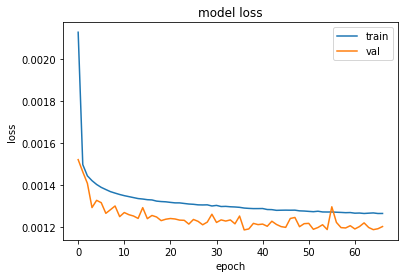

In [5]:
#History
from google.colab import files
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
ax = plt.gca()
#ax.set_ylim([0, 0.05])
plt.savefig('Fig_DNN_CPPTNet_01.png', dpi = 600)
#files.download("Fig_DNN_CPPTNet_01.png")
plt.show()